# Imports

In [1]:
import utils, models_preprocessing, metrics
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import PIL.Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy import stats, integrate
import seaborn as sns
sns.set(color_codes=True)

from keras import models
from keras.models import save_model, load_model
from keras.preprocessing import image
from quiver_engine import server

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Read CSV

In [2]:
parameters = pd.read_csv('classifications.csv', low_memory=False)

In [3]:
parameters.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,6.040000e-10,804,3714.6800
1,100001,0,4.700000e-11,0,0.0000
2,100002,1,7.180000e-11,51,57.6093
3,100003,1,1.760000e-11,347,18815.4000
4,100004,0,2.030000e-09,0,0.0000


# Train model

In [4]:
data = np.load('data/imadjust.npy')
labels = np.load('labels/classification.npy')

In [5]:
model_function = models_preprocessing.compiledConvnet
auroc = metrics.auroc
accuracy = metrics.accuracy
text = metrics.basicTextMetrics

In [6]:
%matplotlib inline

In [7]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, labels, test_size=0.2, shuffle=False)

In [ ]:
model = utils.train(model_function(), 20, Xtrain, Ytrain)

In [8]:
os.makedirs('models', exist_ok=True)
PATH = 'models/'

In [ ]:
save_model(model, f'{PATH}model_cConv.hdf5')

In [9]:
model = load_model(f'{PATH}model_cConv.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 64)        2368      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1936)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               247936    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
__________

# Predictions

In [10]:
preds_test = model.predict_classes(Xtest)
probs_test = model.predict(Xtest)

In [11]:
preds_data = model.predict_classes(data)
probs_data = model.predict(data)

In [12]:
preds_test

array([[1],
       [0],
       [0],
       ..., 
       [0],
       [0],
       [0]], dtype=int32)

# EDA

## Test parameters

In [13]:
parameters.head()

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,6.040000e-10,804,3714.6800
1,100001,0,4.700000e-11,0,0.0000
2,100002,1,7.180000e-11,51,57.6093
3,100003,1,1.760000e-11,347,18815.4000
4,100004,0,2.030000e-09,0,0.0000


In [14]:
test_params = pd.read_csv('classifications.csv', skiprows=range(1, 16001))

In [15]:
test_params.insert(2, 'is_lens_preds', preds_test)

In [16]:
test_params.head()

,ID,is_lens,is_lens_preds,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,116000,0,1,1.720000e-09,0,0.000
1,116001,1,0,8.610000e-12,69,132.736
2,116002,0,0,1.390000e-10,0,0.000
3,116003,1,1,7.060000e-12,120,227.222
4,116004,1,1,1.890000e-09,104,278.564


In [17]:
Einstein_radius = np.sqrt(test_params.Einstein_area / (np.pi))

In [18]:
test_params.insert(4, 'Einstein_radius', Einstein_radius)

In [19]:
test_params.head()

,ID,is_lens,is_lens_preds,Einstein_area,Einstein_radius,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,116000,0,1,1.720000e-09,0.000023,0,0.000
1,116001,1,0,8.610000e-12,0.000002,69,132.736
2,116002,0,0,1.390000e-10,0.000007,0,0.000
3,116003,1,1,7.060000e-12,0.000001,120,227.222
4,116004,1,1,1.890000e-09,0.000025,104,278.564


In [20]:
test_params.insert(3, 'probs', probs_test)

In [21]:
test_params.head()

,ID,is_lens,is_lens_preds,probs,Einstein_area,Einstein_radius,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,116000,0,1,0.999989,1.720000e-09,0.000023,0,0.000
1,116001,1,0,0.101402,8.610000e-12,0.000002,69,132.736
2,116002,0,0,0.000594,1.390000e-10,0.000007,0,0.000
3,116003,1,1,0.999986,7.060000e-12,0.000001,120,227.222
4,116004,1,1,0.999812,1.890000e-09,0.000025,104,278.564


In [70]:
class_type = np.array([' ']*4000).astype(list)
for i in range(len(test_params)):
    if test_params.is_lens[i] == 1 and test_params.is_lens_preds[i] == 1:
        class_type[i] = 'tp'
    elif test_params.is_lens[i] == 0 and test_params.is_lens_preds[i] == 0:
        class_type[i] = 'tn'
    elif test_params.is_lens[i] == 1 and test_params.is_lens_preds[i] == 0:
        class_type[i] = 'fn'
    elif test_params.is_lens[i] == 0 and test_params.is_lens_preds[i] == 1:
        class_type[i] = 'fp'

In [71]:
test_params.insert(3, 'class_type', class_type)

In [72]:
test_params.head()

,ID,is_lens,is_lens_preds,class_type,probs,Einstein_area,Einstein_radius,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,116000,0,1,fp,0.999989,1.720000e-09,0.000023,0,0.000
1,116001,1,0,fn,0.101402,8.610000e-12,0.000002,69,132.736
2,116002,0,0,tn,0.000594,1.390000e-10,0.000007,0,0.000
3,116003,1,1,tp,0.999986,7.060000e-12,0.000001,120,227.222
4,116004,1,1,tp,0.999812,1.890000e-09,0.000025,104,278.564


In [74]:
test_params.to_csv('updated_test_params.csv', index=False)

## Negatives and Positives

In [170]:
negatives = test_params[test_params.is_lens == 0]; positives = test_params[test_params.is_lens == 1]

In [171]:
negatives.head()

,ID,is_lens,is_lens_preds,class_type,probs,Einstein_area,Einstein_radius,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,116000,0,1,fp,0.999989,1.720000e-09,0.000023,0,0.0
2,116002,0,0,tn,0.000594,1.390000e-10,0.000007,0,0.0
6,116006,0,0,tn,0.002157,1.430000e-11,0.000002,0,0.0
7,116007,0,0,tn,0.008905,1.020000e-10,0.000006,0,0.0
9,116009,0,1,fp,0.911055,1.140000e-10,0.000006,0,0.0


In [172]:
positives.head()

,ID,is_lens,is_lens_preds,class_type,probs,Einstein_area,Einstein_radius,numb_pix_lensed_image,flux_lensed_image_in_sigma
1,116001,1,0,fn,0.101402,8.610000e-12,0.000002,69,132.7360
3,116003,1,1,tp,0.999986,7.060000e-12,0.000001,120,227.2220
4,116004,1,1,tp,0.999812,1.890000e-09,0.000025,104,278.5640
5,116005,1,0,fn,0.194538,1.740000e-09,0.000024,20,26.3226
8,116008,1,1,tp,0.999971,7.960000e-11,0.000005,160,249.5430


# Plots

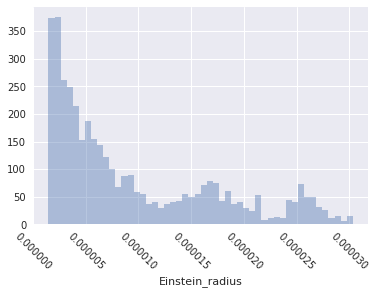

In [73]:
sns.distplot(test_params.Einstein_radius, kde=False, bins=50)
plt.xticks(rotation=-45);

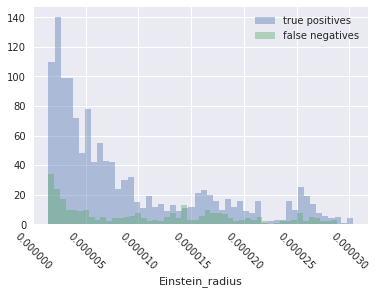

In [75]:
sns.distplot(test_params.Einstein_radius[test_params.class_type == 'tp'], kde=False, bins=50)
sns.distplot(test_params.Einstein_radius[test_params.class_type == 'fn'], kde=False, bins=50)
plt.legend(['true positives', 'false negatives'])
plt.xticks(rotation=-45);

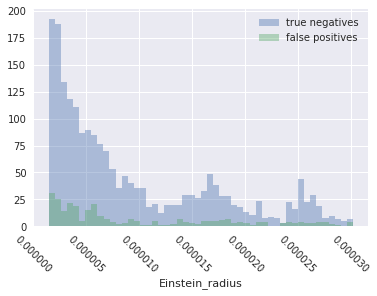

In [76]:
sns.distplot(test_params.Einstein_radius[test_params.class_type == 'tn'], kde=False, bins=50)
sns.distplot(test_params.Einstein_radius[test_params.class_type == 'fp'], kde=False, bins=50)
plt.legend(['true negatives', 'false positives'])
plt.xticks(rotation=-45);

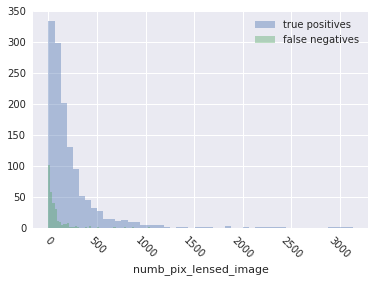

In [77]:
sns.distplot(test_params.numb_pix_lensed_image[test_params.class_type == 'tp'], kde=False, bins=50)
sns.distplot(test_params.numb_pix_lensed_image[test_params.class_type == 'fn'], kde=False, bins=50)
plt.legend(['true positives', 'false negatives'])
plt.xticks(rotation=-45);

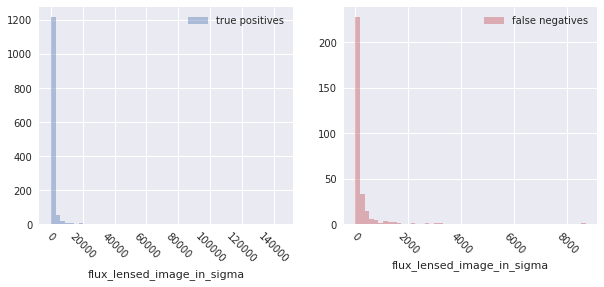

In [105]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.distplot(test_params.flux_lensed_image_in_sigma[test_params.class_type == 'tp'], kde=False, bins=50)
plt.legend(['true positives'])
plt.xticks(rotation=-45);
plt.subplot(1, 2, 2)
sns.distplot(test_params.flux_lensed_image_in_sigma[test_params.class_type == 'fn'], kde=False, bins=50, color='r')
plt.legend(['false negatives'])
plt.xticks(rotation=-45);

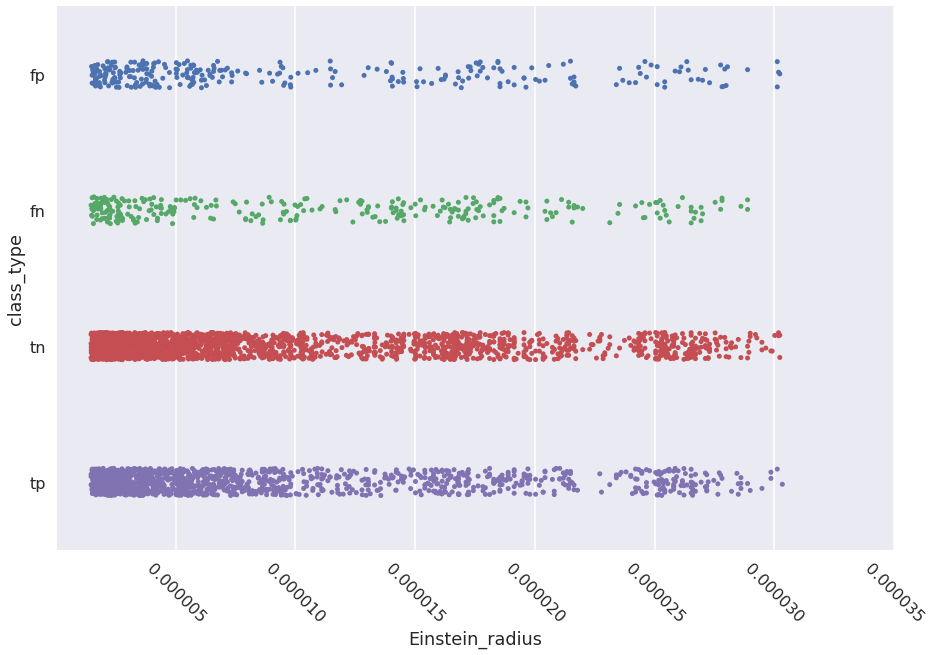

In [174]:
plt.figure(figsize=(15,10))
sns.set_context('poster')
sns.stripplot(x="Einstein_radius", y="class_type", data=test_params, jitter=True)
plt.xlim([0.00000005, 0.000035])
plt.xticks(rotation=-45);

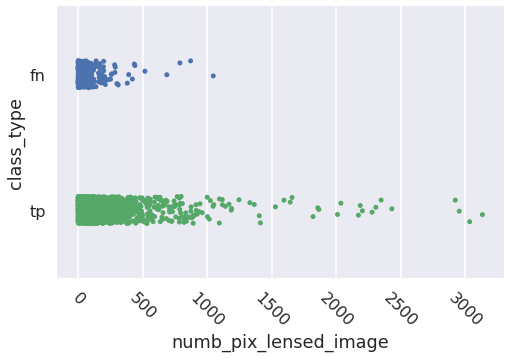

In [175]:
plt.figure(figsize=(8,5))
#sns.set_context('poster')
sns.stripplot(x="numb_pix_lensed_image", y="class_type", data=positives, jitter=True)
#plt.xlim([0.00000005, 0.000035])
plt.xticks(rotation=-45);

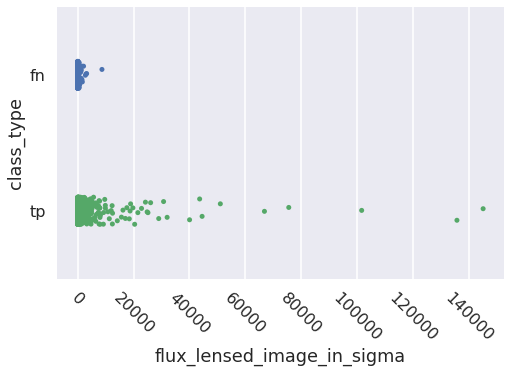

In [176]:
plt.figure(figsize=(8,5))
#sns.set_context('poster')
sns.stripplot(x="flux_lensed_image_in_sigma", y="class_type", data=positives, jitter=True)
#plt.xlim([0.00000005, 0.000035])
plt.xticks(rotation=-45);

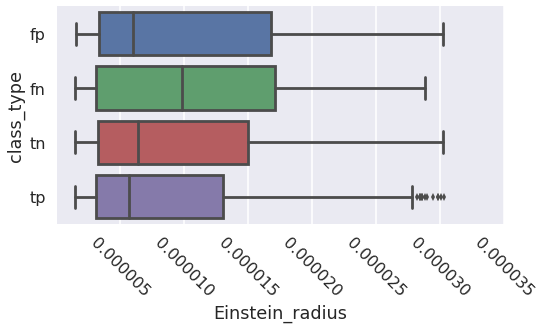

In [152]:
plt.figure(figsize=(8,4))
sns.set_context('poster')
sns.boxplot(x="Einstein_radius", y="class_type", data=test_params)
plt.xlim([0.00000005, 0.000035])
plt.xticks(rotation=-45);

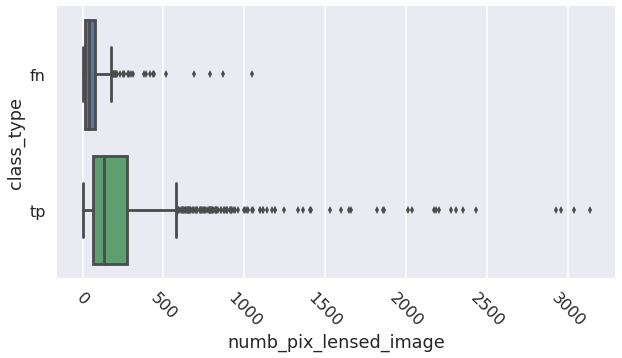

In [265]:
plt.figure(figsize=(10,5))
sns.set_context('poster')
sns.boxplot(x="numb_pix_lensed_image", y="class_type", data=positives)
#plt.xlim([0.00000005, 0.000035])
plt.xticks(rotation=-45);

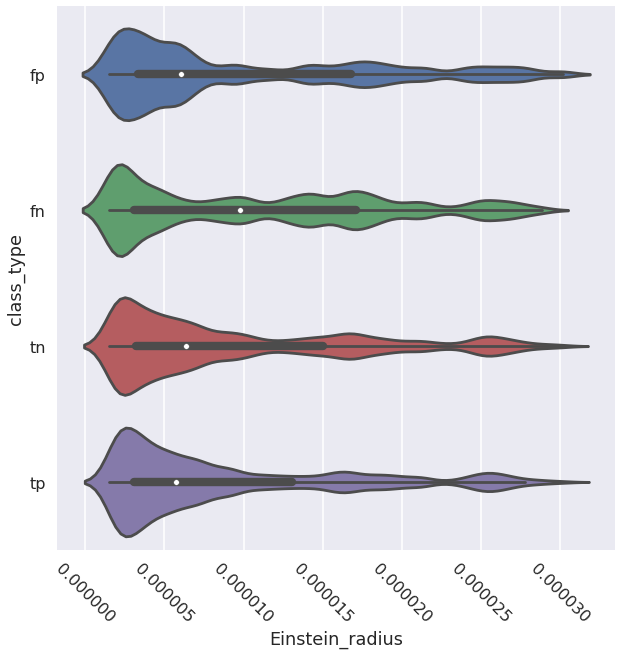

In [169]:
plt.figure(figsize=(10,10))
sns.violinplot(y="class_type", x="Einstein_radius", data=test_params, bw=0.1)
#plt.xlim([0, 0.000035])
plt.xticks(rotation=-45);

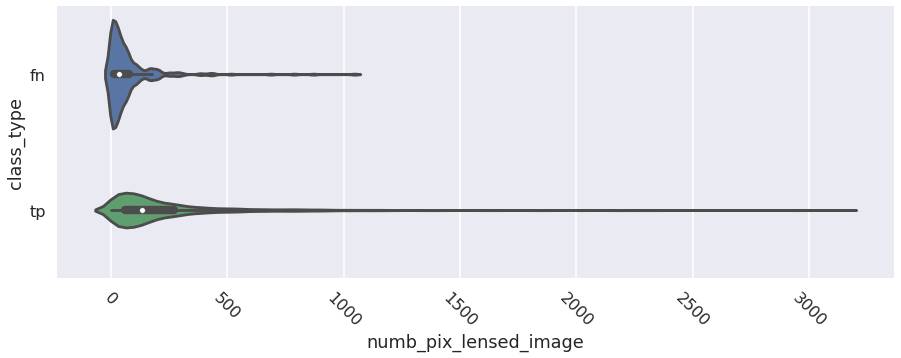

In [185]:
plt.figure(figsize=(15,5))
sns.violinplot(y="class_type", x="numb_pix_lensed_image", data=positives, bw=0.1)
#plt.xlim([0, 0.000035])
plt.xticks(rotation=-45);

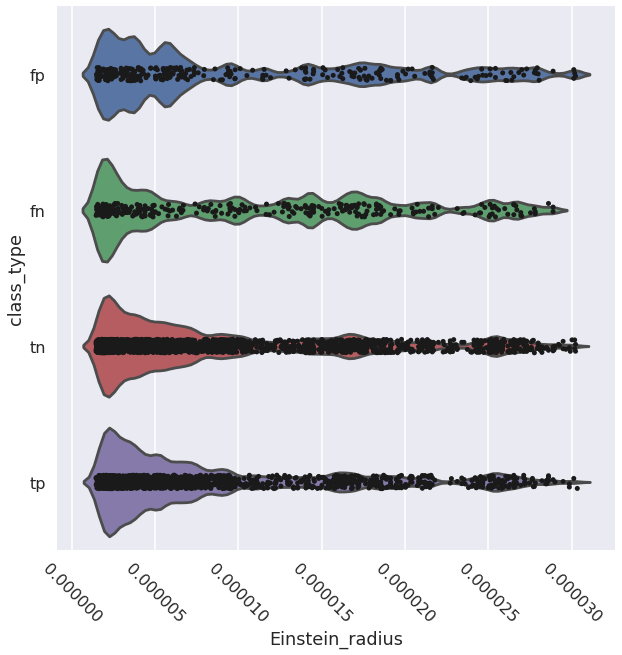

In [234]:
plt.figure(figsize=(10,10))
sns.set_context("poster")
sns.violinplot(y="class_type", x="Einstein_radius", data=test_params, inner=None, bw=0.05)
sns.stripplot(x="Einstein_radius", y="class_type", data=test_params, jitter=0.05, color='k')
#plt.xlim([0, 0.000035])
plt.xticks(rotation=-45);

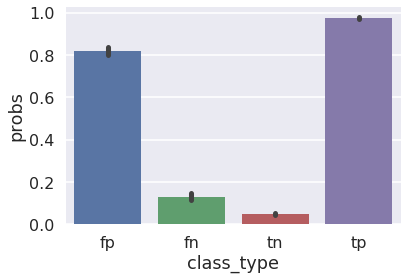

In [266]:
sns.barplot(x="class_type", y="probs", data=test_params);

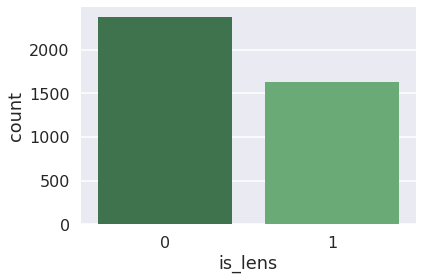

In [267]:
#plt.figure(figsize=(10,10))
sns.countplot(x="is_lens", data=test_params, palette="Greens_d");
#plt.xlim([0, 0.000035])
#plt.xticks(rotation=-45);

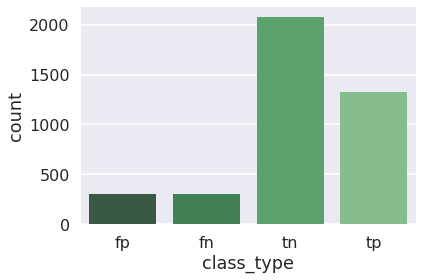

In [268]:
#plt.figure(figsize=(10,10))
sns.countplot(x="class_type", data=test_params, palette="Greens_d");
#plt.xlim([0, 0.000035])
#plt.xticks(rotation=-45);

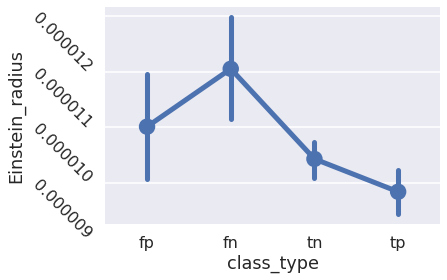

In [214]:
sns.set_context('poster')
sns.pointplot(x="class_type", y="Einstein_radius", data=test_params)
plt.yticks(rotation=-45);

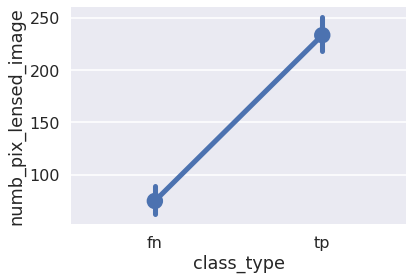

In [215]:
sns.pointplot(x="class_type", y="numb_pix_lensed_image", data=positives);

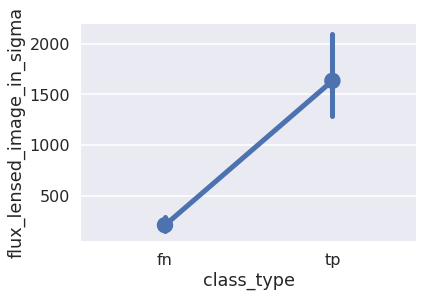

In [216]:
sns.pointplot(x="class_type", y="flux_lensed_image_in_sigma", data=positives);

In [217]:
sns.set()

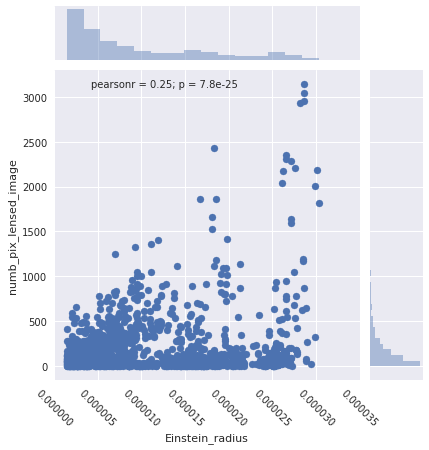

In [220]:
g = sns.jointplot(x='Einstein_radius', y='numb_pix_lensed_image', data=positives, 
                  xlim=(0.00000005, 0.000035))
g.ax_joint.set_xticklabels(g.ax_joint.get_xticklabels(), rotation = -45);

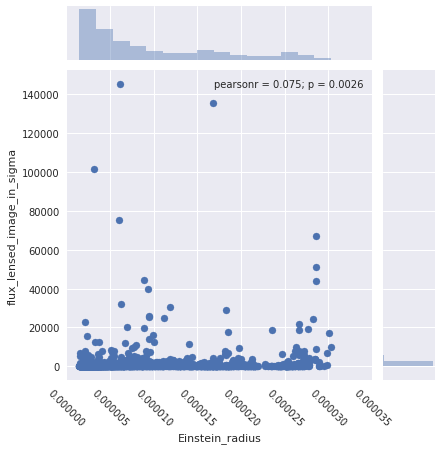

In [221]:
f = sns.jointplot(x='Einstein_radius', y='flux_lensed_image_in_sigma', data=positives, 
              xlim=(0.00000005, 0.000035))
f.ax_joint.set_xticklabels(f.ax_joint.get_xticklabels(), rotation = -45);

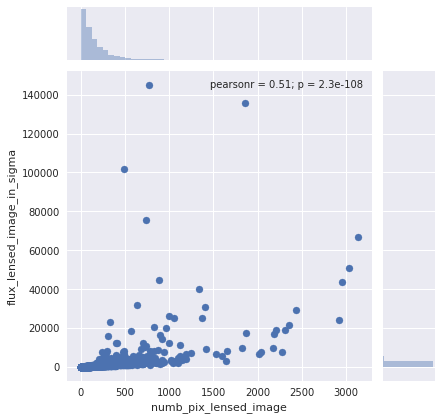

In [260]:
h = sns.jointplot(x='numb_pix_lensed_image', y='flux_lensed_image_in_sigma', data=positives);

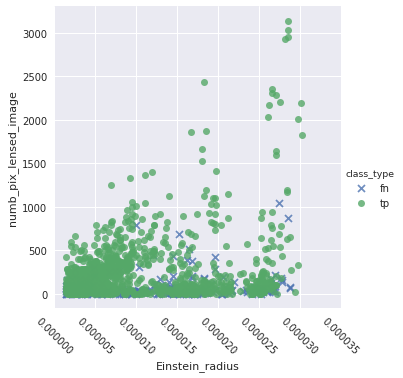

In [257]:
sns.lmplot(x='Einstein_radius', y='numb_pix_lensed_image', data=positives, fit_reg=False, 
           hue='class_type', markers=["x", "o"])
plt.xlim([0.00000005, 0.000035])
plt.xticks(rotation=-45);

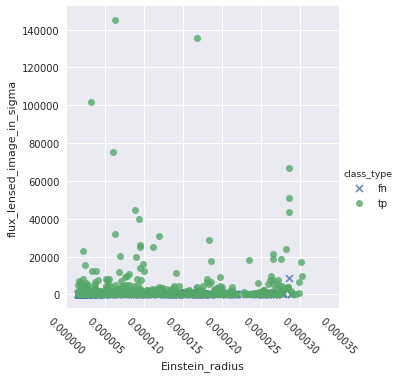

In [258]:
sns.lmplot(x='Einstein_radius', y='flux_lensed_image_in_sigma', data=positives, fit_reg=False, 
           hue='class_type', markers=["x", "o"])
plt.xlim([0.00000005, 0.000035])
plt.xticks(rotation=-45);

In [242]:
stats_df = test_params.drop(['ID', 'is_lens', 'is_lens_preds', 'Einstein_area'], axis=1)

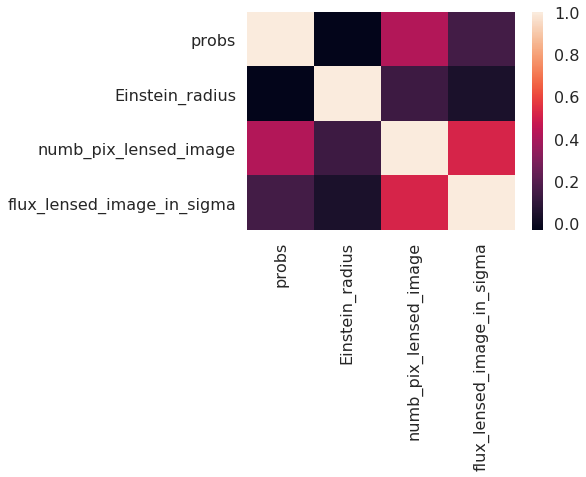

In [243]:
sns.heatmap(stats_df.corr())

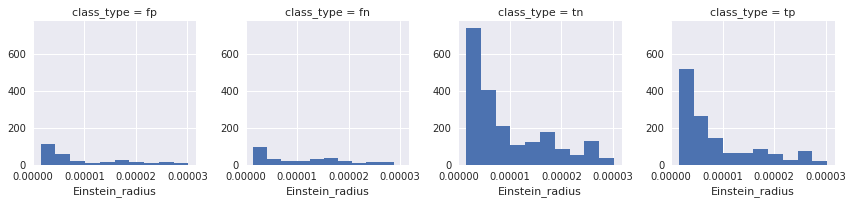

In [261]:
g = sns.FacetGrid(test_params, col="class_type")
g.map(plt.hist, "Einstein_radius");